In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" direASctory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv


**Preprocess the Data**

Convert the 'Date' column to a datetime format.
Normalize the numerical columns (High, Low, Open, Close, Volume, Adj Close) to ensure consistent scale.
Handle any missing values in the dataset.

In [4]:
Yahoo_price_dataset = pd.read_csv('/kaggle/input/time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv')

In [5]:
Yahoo_price_dataset.head(4)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117


In [8]:
Yahoo_price_dataset['Date'] = pd.to_datetime(Yahoo_price_dataset['Date'])

In [18]:
Yahoo_price_dataset.sort_values('Date',inplace=True)

In [19]:
Yahoo_price_dataset.head(4)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117


In [20]:
Yahoo_price_dataset.shape

(1825, 7)

In [21]:
numerical_columns = ['High','Low','Volume','Open','Close','Adj Close']

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Yahoo_price_dataset[numerical_columns]=scaler.fit_transform(Yahoo_price_dataset[numerical_columns])

In [24]:
print(Yahoo_price_dataset.head(5))

        Date      High       Low      Open     Close    Volume  Adj Close
0 2015-11-23  0.138194  0.151554  0.143932  0.143234  0.295740   0.143234
1 2015-11-24  0.137366  0.145353  0.141126  0.144652  0.334066   0.144652
2 2015-11-25  0.136743  0.154297  0.143870  0.144502  0.200874   0.144502
3 2015-11-26  0.136743  0.154297  0.143870  0.144502  0.200874   0.144502
4 2015-11-27  0.136905  0.153084  0.143600  0.145192  0.021979   0.145192


**Feature Engineering**

In [25]:
Yahoo_price_dataset['Day_of_Week'] = Yahoo_price_dataset['Date'].dt.dayofweek

In [27]:
Yahoo_price_dataset['Month'] = Yahoo_price_dataset['Date'].dt.month

In [29]:
Yahoo_price_dataset['Year'] = Yahoo_price_dataset['Date'].dt.year

In [30]:
print(Yahoo_price_dataset.head(5))

        Date      High       Low      Open     Close    Volume  Adj Close  \
0 2015-11-23  0.138194  0.151554  0.143932  0.143234  0.295740   0.143234   
1 2015-11-24  0.137366  0.145353  0.141126  0.144652  0.334066   0.144652   
2 2015-11-25  0.136743  0.154297  0.143870  0.144502  0.200874   0.144502   
3 2015-11-26  0.136743  0.154297  0.143870  0.144502  0.200874   0.144502   
4 2015-11-27  0.136905  0.153084  0.143600  0.145192  0.021979   0.145192   

   Day_of_Week  Month  Year  
0            0     11  2015  
1            1     11  2015  
2            2     11  2015  
3            3     11  2015  
4            4     11  2015  


**Train-Test Split**

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
Features = ['High','Low','Open','Volume','Day_of_Week','Month','Year']
Target = ['Close']

In [33]:
X = Yahoo_price_dataset[Features]
y = Yahoo_price_dataset[Target]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [35]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (1277, 7) (1277, 1)
Testing set shape: (548, 7) (548, 1)


**Create Sequences**

In [36]:
Sequence_length = 20
def Create_Sequence(X,y,Sequence_length):
    X_sequence,y_sequence = [],[]
    for i in range(len(X)-Sequence_length+1):
        X_sequence.append(X.iloc[i:i+ Sequence_length,:].values)
        y_sequence.append(y.iloc[i+Sequence_length-1])
        return np.array(X_sequence),np.array(y_sequence)

In [42]:
X_train_sequences, y_train_sequences = Create_Sequence(X_train, y_train, Sequence_length)
X_test_sequences, y_test_sequences = Create_Sequence(X_test, y_test, Sequence_length)

**Build and Train the LSTM Model**

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [43]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))
model.add(Dense(units=1))

In [44]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
model.fit(X_train_sequences, y_train_sequences, epochs=10, batch_size=32)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 781050.8750
Epoch 2/10
1/1 [==============================] - 0s 11ms/step - loss: 5105859.0000
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 499243.3438
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 437181.8125
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 2906240.7500
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 419.0555
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 62262.5312
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 109605.9766
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 1280.1466
Epoch 10/10
1/1 [==============================] - 0s 8ms/step - loss: 8951.5488


In [46]:
mse = model.evaluate(X_test_sequences, y_test_sequences)
print(f'Mean Squared Error on Testing Set: {mse}')

1/1 [==============================] - 0s 197ms/step - loss: 2041.8839
Mean Squared Error on Testing Set: 2041.8839111328125


**Evaluate the Model:**

In [48]:
mse = model.evaluate(X_test_sequences, y_test_sequences)
print(f'Mean Squared Error on Testing Set: {mse}')

1/1 [==============================] - 0s 19ms/step - loss: 2041.8839
Mean Squared Error on Testing Set: 2041.8839111328125


In [49]:
mae = np.mean(np.abs(model.predict(X_test_sequences).flatten() - y_test_sequences))
print(f'Mean Absolute Error on Testing Set: {mae}')

1/1 [==============================] - 0s 165ms/step
Mean Absolute Error on Testing Set: 45.187211405795885


In [51]:
import matplotlib.pyplot as plt

In [52]:
plt.figure(figsize=(12,6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

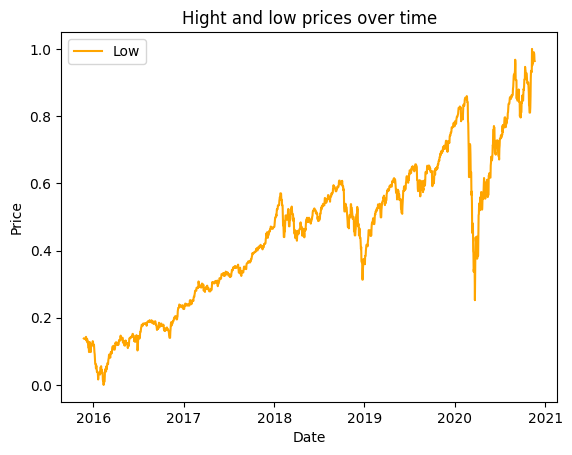

In [54]:
plt.plot(Yahoo_price_dataset['Date'],Yahoo_price_dataset['High'],label = 'Low',color='orange')
plt.title('Hight and low prices over time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

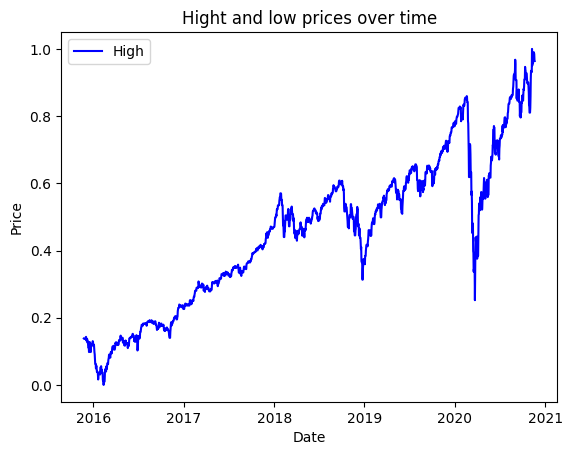

In [55]:
plt.plot(Yahoo_price_dataset['Date'],Yahoo_price_dataset['High'],label = 'High',color = 'blue')
plt.title('Hight and low prices over time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()